In [10]:
import sys
import os
from os import path
import glob
import numpy as np
from kaldi.feat.mfcc import Mfcc, MfccOptions
import scipy.io.wavfile as wav
from main import SpeechProcessing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams['figure.figsize'] = [15, 5]

16000


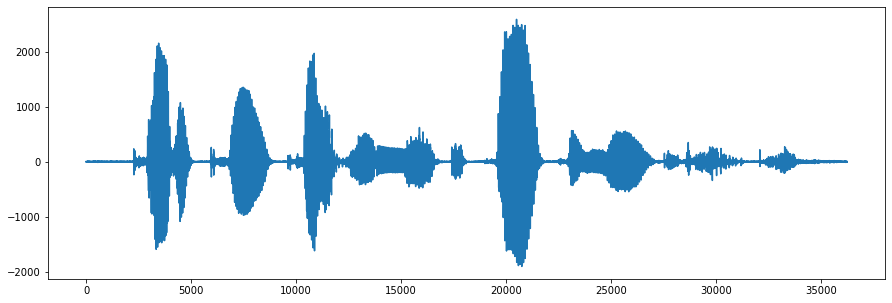

In [2]:
base_path = "./"
wav_path= path.join(base_path,"wav","test.wav")
model_path = path.join(base_path,"models","SOM_TIMIT_MFCC_35X1_10022022")
speech = SpeechProcessing()
io = speech.IO()
sr, sig = io.read_wav(wav_path)
print(sr)
plt.plot(sig)
    

(226, 39)


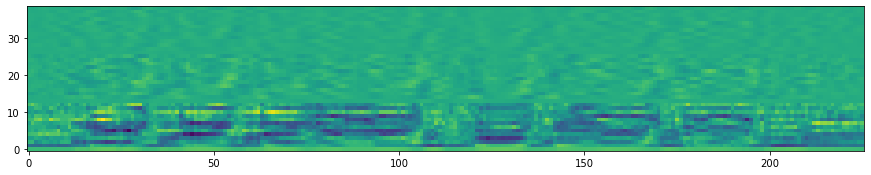

In [14]:
feats_proc = speech.FeatsProcessor()
mfcc_feats = feats_proc.generate_mfcc(sr, sig)
print(mfcc_feats.shape)
fix, ax = plt.subplots()
ax.imshow(mfcc_feats.transpose())
ax.invert_yaxis()
plt.show()

In [4]:
som = speech.SOM()
som_labels_map = som.generate_som_labels(mfcc_feats,model_path)
print(som_labels_map)

    FrameID ClusterID
0         0         7
1         1         7
2         2        26
3         3        26
4         4         7
..      ...       ...
221     221        29
222     222        20
223     223         7
224     224         7
225     225         7

[226 rows x 2 columns]


Label expored successfully...


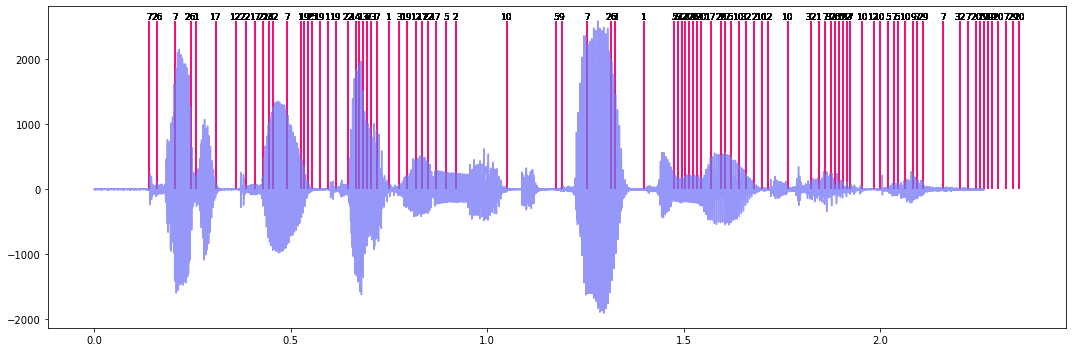

In [5]:
lm = speech.LM()
# display the label sequence with reduced label sequence 
fig, axs = plt.subplots(1,1, tight_layout=True)
times = np.arange(len(sig))/float(sr)
axs.plot(times, sig, color='#7274f7', alpha=0.75)
max_amp = np.max(sig)
cluster_arr = som_labels_map.iloc[:,1].to_numpy()
lbl_path = lm.generate_pseudo_label(cluster_arr,base_path,"test")
df_lbl = pd.read_csv(lbl_path, sep=',', header=1)
lbl_t_st = df_lbl.iloc[:,3].to_numpy()
lbl_t_end = df_lbl.iloc[:,4].to_numpy()
lbl_state = df_lbl.iloc[:,5].to_numpy()
y_lbl_arr = gaussian_filter1d(lbl_state, sigma=0.001) # for plot purpose only
lbl_st_dur = []
for i in range(len(lbl_t_end)): 
    deviation = (lbl_t_end[i]-lbl_t_st[i])/2
    lbl_st_dur.append(lbl_t_st[i]+deviation+0.01)

y_lbl_st = [lbl_state[i]*(0.16/35) for i in range(len(lbl_state))]
y_unit_scale = max_amp/35
for i, t1 in enumerate(lbl_t_end): 
    deviation = (lbl_t_end[i]-lbl_t_st[i])/2
    axs.vlines(lbl_t_st[i]+deviation+0.01,ymin=0, ymax=max_amp,linewidth=2, color='#f70f77')
    axs.text(lbl_t_st[i]+deviation+0.01, max_amp-0.003, s=round(lbl_state[i], 1), horizontalalignment= 'center',verticalalignment='bottom',fontsize='9',color='black')
plt.show()

In [15]:
# compute the similarity between two SOM label sequences 
f_name_x = "speaker_x"
f_name_y = "speaker_y"
clus_seq_x = path.join(base_path,"ClusterID","{}.csv".format(f_name_x))
clus_seq_y = path.join(base_path,"ClusterID","{}.csv".format(f_name_y))
lbl_seq_x= path.join(base_path,"Label","{}.lbl".format(f_name_x))
lbl_seq_y= path.join(base_path,"Label","{}.lbl".format(f_name_y))

df_lbl1 = pd.read_csv(lbl_seq_x, sep=',', header=1)
lbl_t_st1 = df_lbl1.iloc[:,3].to_numpy()
lbl_t_end1 = df_lbl1.iloc[:,4].to_numpy()
lbl_state1 = df_lbl1.iloc[:,5].to_numpy()
y_lbl_st1 = [lbl_state1[i]*(0.16/35) for i in range(len(lbl_state1))]

df_lbl2 = pd.read_csv(lbl_seq_y, sep=',', header=1)
lbl_t_st2 = df_lbl2.iloc[:,3].to_numpy()
lbl_t_end2 = df_lbl2.iloc[:,4].to_numpy()
lbl_state2 = df_lbl2.iloc[:,5].to_numpy()
y_lbl_st2 = [lbl_state2[i]*(0.16/35) for i in range(len(lbl_state2))]

df1 = pd.read_csv(clus_seq_x, header=None)
cluster_arr1 = df1.iloc[:,1].to_numpy()
index_arr1 = df1.iloc[:,0].to_numpy()
seq1 = cluster_arr1
str_states1 = ",".join(map(str,cluster_arr1))

df2 = pd.read_csv(clus_seq_y, header=None)
cluster_arr2 = df2.iloc[:,1].to_numpy()
index_arr2 = df2.iloc[:,0].to_numpy()
seq2 = cluster_arr2
str_states2 = ",".join(map(str,cluster_arr2))

seq_query_x = lm.reduce_frame_label(str_states1)
seq_query_y = lm.reduce_frame_label(str_states2)
print(seq_query_x)	
print(seq_query_y)

H, steady_match_list = lm.sim_tracer(seq_query_x, seq_query_y)
unique_seq = np.unique(steady_match_list)
print(H)
print(unique_seq)



0|4|28|2|11|7|25|7|25|8|7|8|7|25|24|30|31|20|31|20|11|14|19|34|23|6|7|14|24|34|18|15|2|13|26|14|3|19|4|28|2|14|20|18|29|21|5|25|7|25|33|6|7|8|7|5|14|24|34|18|23|15|26|9|33|15|6|25|7|5|25|17|18|22|6|7|5|25|7|8|29|12|18|23|6|7|25|7|5|14|24|3|19|4|28|2|14|10|29|17|23|6|25|14|24|3|19|4|0|4|23|28|2|11|14|29|5|25|17|7|25|17|33|9|3|32|3|4|0|4|23|28|2|14|32|19|4|0
0|4|28|2|11|29|25|33|34|18|15|7|15|2|13|7|25|30|31|20|14|19|4|23|28|13|26|7|25|8|34|18|1|7|26|14|3|19|23|28|2|14|20|27|29|21|7|25|7|8|7|5|14|24|34|23|15|13|26|9|17|6|7|25|17|8|6|7|25|24|3|34|18|23|15|6|7|25|7|25|14|24|3|34|23|28|2|14|23|28|13|26|14|24|3|19|4|0|32|19|4|23|28|2|11|14|25|33|6|7|25|14|24|19|32|3|4|0|32|0
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 1 0 1]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 1 0 1]]
['0' '0|4' '0|4|28' '0|4|28|2' '0|4|28|2|11' '11' '13|26' '14' '14|19'
 '14|24' '15' '15|2|13' '17' '18' '19' '2' '20' '23' '24' '25' '25|33'
 '26' '26|14|3' '26|9' '28' '28|2' '28|2|11' '29' '29|21' '3

121 --> 139
139 --> 121


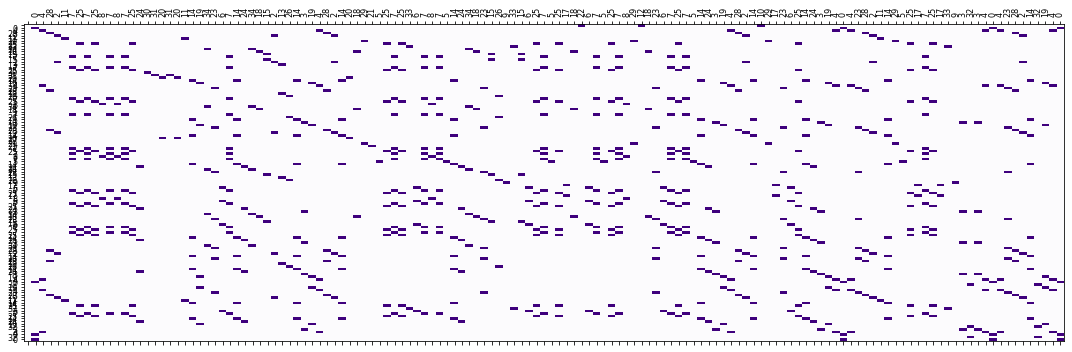

In [16]:
#-------------------- plot area ------------------- #
x_lbls = seq_query_y.split('|')
x_labels = ['' for i in range(len(x_lbls)+1)]

for i,lbl in enumerate(x_lbls): 
    x_labels[i+1] = str(lbl)

x_labels[0]=''
y_lbls = seq_query_x.split('|')
y_labels = ['' for i in range(len(y_lbls)+1)]

for i, lbl in enumerate(y_lbls): 
    y_labels[i+1] = str(lbl)

y_labels[0]=''	

print(len(x_labels),"-->", H.shape[0])
print(len(y_labels),"-->", H.shape[1])

x_axis = [i for i in range(len(x_labels))]
y_axis = [i for i in range(len(y_labels))]

fig, ax4 = plt.subplots()
H_t = np.transpose(H)
ax4.matshow(H_t, interpolation='nearest', aspect='auto', cmap=plt.cm.Purples)
ax4.set_xticks(y_axis)
ax4.set_xticklabels(y_labels, rotation=90, fontsize=8)
ax4.set_yticks(x_axis)
ax4.set_yticklabels(x_labels, fontsize=8)
ax4.xaxis.set_minor_locator(ticker.MultipleLocator(5))

#fig.colorbar(cax)
plt.tight_layout()
plt.show()